In [12]:
import tensorflow as tf
import pandas as pd
import math
import numpy
from tensorflow import keras

SHUFFLE_BUFFER = 500
BATCH_SIZE = 36
EPOCHS = 30

In [13]:
data = pd.read_csv('data/prepared_data.csv')

TRAINING_SIZE = math.floor(0.5*len(data))
TEST_SIZE = math.floor(0.3*len(data))
EVALUATION_SIZE = math.floor(0.2*len(data))

indices = (TRAINING_SIZE, TRAINING_SIZE+TEST_SIZE, TRAINING_SIZE+TEST_SIZE+EVALUATION_SIZE)
inputs = ['ra', 'dec', 'u', 'g', 'r', 'i', 'z', 'redshift']
outputs = ['class_GALAXY','class_QSO','class_STAR']

training = data[0:indices[0]]
test = data[indices[0]:indices[1]]
evaluation = data[indices[1]:indices[2]]
professor = {
	"training": {
		"questions": training[inputs],
		"answers": training[outputs]
	},
	"test": {
		"questions": test[inputs],
		"answers": test[outputs]
	},
	"evaluation": {
		"questions": evaluation[inputs],
		"answers": evaluation[outputs]
	}
}

In [14]:
def cgd(tups):
	print(tups)
	return tups
class CGD(tf.keras.optimizers.SGD):
	def __init__(self) -> None:
	    super().__init__()


In [15]:
normalizer = keras.layers.Normalization(axis=-1)
normalizer.adapt(data[['ra', 'dec', 'u', 'g', 'r', 'i', 'z', 'redshift']])

model = keras.Sequential([
	normalizer,
	keras.layers.Dense(9, activation='relu'),
	keras.layers.Dense(9, activation='relu'),
	keras.layers.Dense(3, activation='sigmoid')
])


model.compile(
	CGD(),
	loss=keras.losses.BinaryCrossentropy(),
	metrics=['accuracy']
)

history = model.fit(professor['training']['questions'], professor['training']['answers'], validation_data=(professor['test']['questions'], professor['test']['answers']), epochs=EPOCHS, batch_size=BATCH_SIZE)

Epoch 1/30
139/139 [==============================] - 1s 2ms/step - loss: 0.7016 - accuracy: 0.4066 - val_loss: 0.6673 - val_accuracy: 0.3737
Epoch 2/30
139/139 [==============================] - 0s 2ms/step - loss: 0.6523 - accuracy: 0.4144 - val_loss: 0.6394 - val_accuracy: 0.4257
Epoch 3/30
139/139 [==============================] - 0s 1ms/step - loss: 0.6282 - accuracy: 0.4822 - val_loss: 0.6231 - val_accuracy: 0.4487
Epoch 4/30
139/139 [==============================] - 0s 3ms/step - loss: 0.6137 - accuracy: 0.4902 - val_loss: 0.6122 - val_accuracy: 0.4493
Epoch 5/30
139/139 [==============================] - 0s 2ms/step - loss: 0.6038 - accuracy: 0.4968 - val_loss: 0.6041 - val_accuracy: 0.4703
Epoch 6/30
139/139 [==============================] - 0s 1ms/step - loss: 0.5966 - accuracy: 0.5304 - val_loss: 0.5979 - val_accuracy: 0.4983
Epoch 7/30
139/139 [==============================] - 0s 1ms/step - loss: 0.5910 - accuracy: 0.5668 - val_loss: 0.5928 - val_accuracy: 0.5337
Epoch 

In [16]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_4 (Normalizati (None, 8)                 17        
_________________________________________________________________
dense_12 (Dense)             (None, 9)                 81        
_________________________________________________________________
dense_13 (Dense)             (None, 9)                 90        
_________________________________________________________________
dense_14 (Dense)             (None, 3)                 30        
Total params: 218
Trainable params: 201
Non-trainable params: 17
_________________________________________________________________


In [17]:
evaluation.head(5)

,Unnamed: 0,ra,dec,u,g,r,i,z,redshift,class_GALAXY,class_QSO,class_STAR
8000,8000,0.190349,-0.599724,-0.079026,-0.204305,-0.154887,-0.110684,-0.030056,-0.370001,0.1,0.1,0.9
8001,8001,0.188651,-0.598305,0.745707,0.702019,0.629892,0.602372,0.601848,-0.367239,0.1,0.1,0.9
8002,8002,0.190667,-0.604786,1.004693,0.648648,0.312791,0.092810,-0.032583,-0.091988,0.9,0.1,0.1
8003,8003,0.191552,-0.603357,0.394077,1.518491,1.645257,1.595851,1.568480,3.531147,0.1,0.9,0.1
8004,8004,0.191230,-0.598623,-1.215336,-1.586335,-1.722162,-1.761351,-1.850619,-0.164494,0.9,0.1,0.1


In [18]:
model.__call__(professor['evaluation']['questions'].head(5))

<tf.Tensor: shape=(5, 3), dtype=float32, numpy=
array([[0.4587853 , 0.10058913, 0.61893904],
       [0.45474654, 0.10623825, 0.54063606],
       [0.65270674, 0.23475322, 0.21395564],
       [0.25587186, 0.91146755, 0.05107963],
       [0.5326971 , 0.10572505, 0.40753046]], dtype=float32)>

In [19]:
# def create_model(input_shape=11, output_shape=3):
#     m = keras.Sequential(
#         [
#             tf.keras.layers.Dense(40, activation='relu', input_dim=input_shape),  # input shape required
#             tf.keras.layers.Dense(40, activation='relu'),
#             tf.keras.layers.Dense(20, activation='relu'),
#             tf.keras.layers.Dense(output_shape, activation='softmax')
#         ]
#     )
#     return m
# lr_schedule = keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate=3e-5,
#     decay_steps=10000,
#     decay_rate=0.9
# )
# optimizer = keras.optimizers.SGD(learning_rate=lr_schedule)
# # Instantiate a loss function.
# loss_fn = keras.losses.CategoricalCrossentropy(from_logits=True)
# model = create_model(8)
# model.compile(loss=loss_fn, optimizer='sgd', metrics=["accuracy"])
# history = model.fit(professor['training']['questions'], professor['training']['answers'], validation_data=(professor['test']['questions'], professor['test']['answers']), batch_size=36, epochs=50, verbose=1)

In [ ]:
history

Text(0.5, 1.0, 'Training and Validation Accuracy')

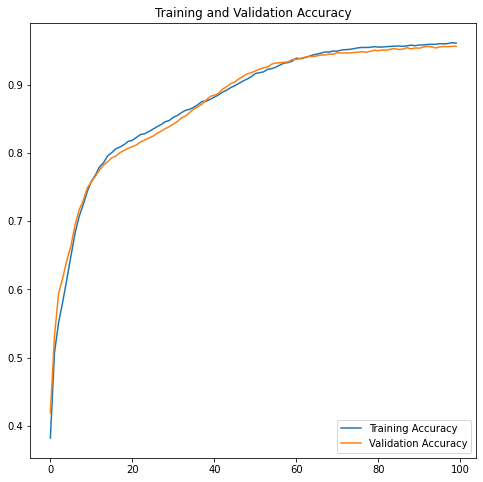

In [ ]:

import matplotlib.pyplot as plt
epochs_range = range(EPOCHS)
plt.figure(figsize=(8, 8))
plt.plot(epochs_range, history.history["accuracy"], label='Training Accuracy')
plt.plot(epochs_range, history.history["val_accuracy"], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

In [ ]:
import pickle
with open("simple_model.pkl", "a") as f:
	pickle.dump(model, f)

AttributeError: Can't pickle local object 'PreprocessingLayer.make_adapt_function.<locals>.adapt_step'

In [43]:
#! /usr/bin/env python
# -*- coding: utf-8 -*-
# vim:fenc=utf-8
#
# Copyright © 2019 Pi-Yueh Chuang <pychuang@gwu.edu>
#
# Distributed under terms of the MIT license.

"""An example of using tfp.optimizer.lbfgs_minimize to optimize a TensorFlow model.

This code shows a naive way to wrap a tf.keras.Model and optimize it with the L-BFGS
optimizer from TensorFlow Probability.

Python interpreter version: 3.6.9
TensorFlow version: 2.0.0
TensorFlow Probability version: 0.8.0
NumPy version: 1.17.2
Matplotlib version: 3.1.1
"""
import numpy
import tensorflow as tf
import tensorflow_probability as tfp
from matplotlib import pyplot

def function_factory(model, loss, train_x, train_y):
    """A factory to create a function required by tfp.optimizer.lbfgs_minimize.

    Args:
        model [in]: an instance of `tf.keras.Model` or its subclasses.
        loss [in]: a function with signature loss_value = loss(pred_y, true_y).
        train_x [in]: the input part of training data.
        train_y [in]: the output part of training data.

    Returns:
        A function that has a signature of:
            loss_value, gradients = f(model_parameters).
    """

    # obtain the shapes of all trainable parameters in the model
    shapes = tf.shape_n(model.trainable_variables)
    n_tensors = len(shapes)

    # we'll use tf.dynamic_stitch and tf.dynamic_partition later, so we need to
    # prepare required information first
    count = 0
    idx = [] # stitch indices
    part = [] # partition indices

    for i, shape in enumerate(shapes):
        n = numpy.product(shape)
        idx.append(tf.reshape(tf.range(count, count+n, dtype=tf.int32), shape))
        part.extend([i]*n)
        count += n

    part = tf.constant(part)

    @tf.function
    def assign_new_model_parameters(params_1d):
        """A function updating the model's parameters with a 1D tf.Tensor.

        Args:
            params_1d [in]: a 1D tf.Tensor representing the model's trainable parameters.
        """

        params = tf.dynamic_partition(params_1d, part, n_tensors)
        for i, (shape, param) in enumerate(zip(shapes, params)):
            model.trainable_variables[i].assign(tf.reshape(param, shape))

    # now create a function that will be returned by this factory
    @tf.function
    def f(params_1d):
        """A function that can be used by tfp.optimizer.lbfgs_minimize.

        This function is created by function_factory.

        Args:
           params_1d [in]: a 1D tf.Tensor.

        Returns:
            A scalar loss and the gradients w.r.t. the `params_1d`.
        """

        # use GradientTape so that we can calculate the gradient of loss w.r.t. parameters
        with tf.GradientTape() as tape:
            # update the parameters in the model
            assign_new_model_parameters(params_1d)
            # calculate the loss
            loss_value = loss(model(train_x, training=True), train_y)

        # calculate gradients and convert to 1D tf.Tensor
        grads = tape.gradient(loss_value, model.trainable_variables)
        grads = tf.dynamic_stitch(idx, grads)

        # print out iteration & loss
        f.iter.assign_add(1)
        # tf.print("Iter:", f.iter, "loss:", loss_value)
        print(grads)

        # store loss value so we can retrieve later
        tf.py_function(f.history.append, inp=[loss_value], Tout=[])

        return loss_value, grads

    # store these information as members so we can use them outside the scope
    f.iter = tf.Variable(0)
    f.idx = idx
    f.part = part
    f.shapes = shapes
    f.assign_new_model_parameters = assign_new_model_parameters
    f.history = []

    return f

def plot_helper(inputs, outputs, title, fname):
    """Plot helper"""
    pyplot.figure()
    pyplot.tricontourf(inputs[:, 0], inputs[:, 1], outputs.flatten(), 100)
    pyplot.xlabel("x")
    pyplot.ylabel("y")
    pyplot.title(title)
    pyplot.colorbar()
    pyplot.savefig(fname)

if __name__ == "__main__":

    # use float64 by default
    tf.keras.backend.set_floatx("float64")

    # prepare prediction model, loss function, and the function passed to L-BFGS solver
    pred_model = tf.keras.Sequential(
        [normalizer,
         tf.keras.layers.Dense(9, "relu"),
         tf.keras.layers.Dense(9, "relu"),
         tf.keras.layers.Dense(3, "sigmoid")])

    func = function_factory(pred_model, tf.keras.losses.BinaryCrossentropy(), professor['training']['questions'], professor['training']['answers'])

    # convert initial model parameters to a 1D tf.Tensor
    init_params = tf.dynamic_stitch(func.idx, pred_model.trainable_variables)

    # train the model with L-BFGS solver
    results = tfp.optimizer.lbfgs_minimize(
        value_and_gradients_function=func, initial_position=init_params, max_iterations=500)

    # after training, the final optimized parameters are still in results.position
    # so we have to manually put them back to the model
    func.assign_new_model_parameters(results.position)

    # do some prediction
    pred_outs = pred_model.predict(professor['test']['questions'])
    print("L2-error norm: {}".format(numpy.linalg.norm(err)/numpy.sqrt(11)))


    # print out history
    print("\n"+"="*80)
    print("History")
    print("="*80)
    print(*func.history, sep='\n')

Tensor("DynamicStitch:0", shape=(201,), dtype=float64)
L2-error norm: 0.0021694660572233624

History
tf.Tensor(1.1413711309432983, shape=(), dtype=float64)
tf.Tensor(1.0628472566604614, shape=(), dtype=float64)
tf.Tensor(0.8951573967933655, shape=(), dtype=float64)
tf.Tensor(0.8369911313056946, shape=(), dtype=float64)
tf.Tensor(0.8366910219192505, shape=(), dtype=float64)
tf.Tensor(0.80682373046875, shape=(), dtype=float64)
tf.Tensor(0.8384192585945129, shape=(), dtype=float64)
tf.Tensor(0.836879312992096, shape=(), dtype=float64)
tf.Tensor(0.796928346157074, shape=(), dtype=float64)
tf.Tensor(0.7547638416290283, shape=(), dtype=float64)
tf.Tensor(0.7546207308769226, shape=(), dtype=float64)
tf.Tensor(0.8116140365600586, shape=(), dtype=float64)
tf.Tensor(0.7915165424346924, shape=(), dtype=float64)
tf.Tensor(0.7557708621025085, shape=(), dtype=float64)
tf.Tensor(0.7465876936912537, shape=(), dtype=float64)
tf.Tensor(0.7291015386581421, shape=(), dtype=float64)
tf.Tensor(0.67504733800

In [44]:
evaluation.head(5)

,Unnamed: 0,ra,dec,u,g,r,i,z,redshift,class_GALAXY,class_QSO,class_STAR
8000,8000,0.190349,-0.599724,-0.079026,-0.204305,-0.154887,-0.110684,-0.030056,-0.370001,0.1,0.1,0.9
8001,8001,0.188651,-0.598305,0.745707,0.702019,0.629892,0.602372,0.601848,-0.367239,0.1,0.1,0.9
8002,8002,0.190667,-0.604786,1.004693,0.648648,0.312791,0.092810,-0.032583,-0.091988,0.9,0.1,0.1
8003,8003,0.191552,-0.603357,0.394077,1.518491,1.645257,1.595851,1.568480,3.531147,0.1,0.9,0.1
8004,8004,0.191230,-0.598623,-1.215336,-1.586335,-1.722162,-1.761351,-1.850619,-0.164494,0.9,0.1,0.1


In [45]:
pred_model.__call__(professor['evaluation']['questions'].head(5))

<tf.Tensor: shape=(5, 3), dtype=float64, numpy=
array([[5.27983390e-028, 3.42950138e-204, 1.00000000e+000],
       [9.41174609e-008, 2.05124057e-130, 1.00000000e+000],
       [1.00000000e+000, 8.30128819e-203, 7.03311393e-081],
       [8.75108805e-263, 0.00000000e+000, 5.87449560e-301],
       [1.00000000e+000, 0.00000000e+000, 2.87483878e-166]])>

In [31]:
import matplotlib.pyplot as plt
epochs_range = range(EPOCHS)
plt.figure(figsize=(8, 8))
plt.plot(epochs_range, func.history["accuracy"], label='Training Accuracy')
plt.plot(epochs_range, func.history["val_accuracy"], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

TypeError: list indices must be integers or slices, not str

<Figure size 576x576 with 0 Axes>